# Lab 06-2 - Fitting Homography Transformations

In this exercise, we will extend the algorithms in previous exercise to find the best model for Homography transformations from a set of correspondences.

## 6-2.0 Setup and Utilities Functions

First, make sure you have installed the required libraries and check what is your *present working directory*:

In [ ]:
!pip install numpy matplotlib opencv-python
!echo "Your current directory is: $(pwd)"

You are provided with some utility functions for reading, writing, and rendering images.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

def plot_points(x, xp):

  # Create the plot
  plt.figure(figsize=(12, 6))

  # Scatter plot for the first two columns
  plt.subplot(1, 2, 1)
  plt.scatter(x[:,0], x[:,1], 1, c='blue', alpha=1)
  plt.title('Scatter Plot of First Set')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.grid(True)

  # Scatter plot for the third and fourth columns
  plt.subplot(1, 2, 2)
  plt.scatter(xp[:,0], xp[:,1], 1, c='red', alpha=1)
  plt.title('Scatter Plot of Second Set')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.grid(True)

  # Show both plots
  plt.tight_layout()
  plt.show()

## 6.1 Fitting Homography Transformations using least-square methods

Suppose we have a set of 2D correspondences $(x_i,y_i)\leftrightarrow(x'_i,y'_i)$ for $1{\le}i{\le}N$. An actual set of points is in `points_case_2.npy` where each row of the matrix contains the data $(x_i,y_i,x'_i, y'_i)$ representing the correspondence.

Size of dataset1: (4558, 4)


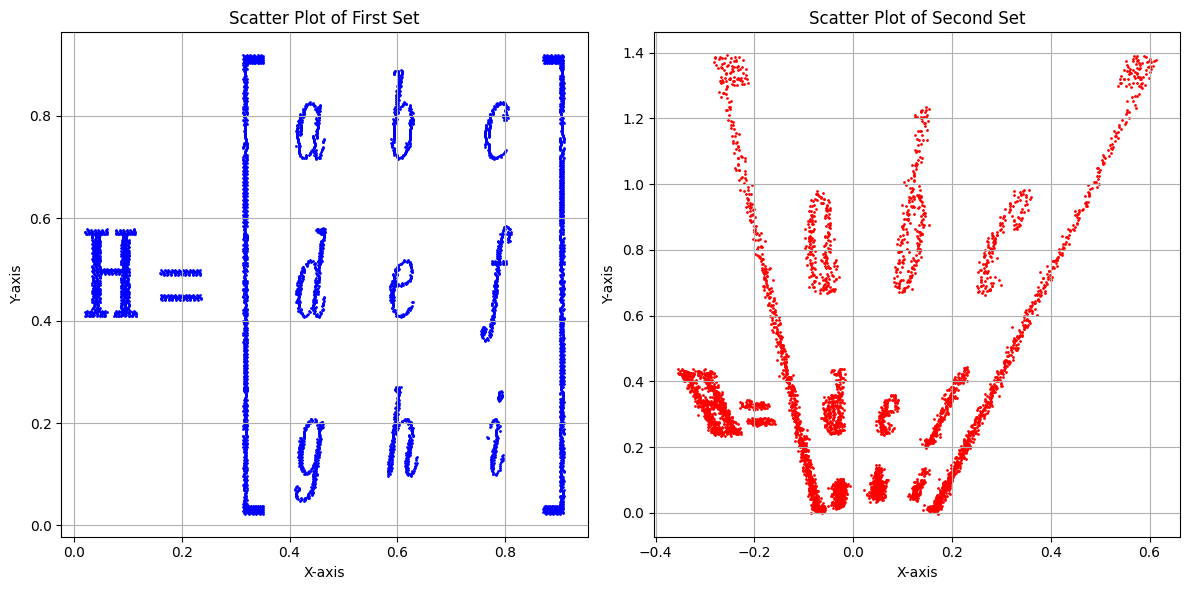

In [ ]:
data = np.load("points_case_2.npy")

print(f"Size of dataset1: {data.shape}")

# Extract x and y coordinates from the first two columns
x = data[:, :2]  # First two columns

# Extract x' and y' coordinates from the third and fourth columns
xp = data[:, -2:]  # Last two columns

plot_points(x, xp)

Fit a transformation of the form

$$
\textbf{p}'_i \equiv \textbf{H}\textbf{p}_i\ ,\ \text{where}\ \textbf{p}_i=
\left[ \begin{matrix}
x_i \\
y_i \\
w_i
\end{matrix} \right]\ \text{and}\
\textbf{H} =
\left[ \begin{matrix}
h_{11} & h_{12} & h_{13} \\
h_{21} & h_{22} & h_{23} \\
h_{31} & h_{32} & h_{33}
\end{matrix} \right]
=
\left[ \begin{matrix}
\textbf{h}^T_1 \\
\textbf{h}^T_2 \\
\textbf{h}^T_3
\end{matrix} \right]
$$

This setup is a trickier and depends on homogeneous coordinates. The problem is that we test homogeneous equivalence ($\textbf{x}\equiv\textbf{y}$), which is true if and only if the two vectors are proportional (there is a $\lambda \neq 0$ such that $\textbf{x}=\lambda\textbf{y}$). The trick is to use the cross product. If $\textbf{x}$ and $\textbf{y}$ are proportional, $\textbf{x}\times\textbf{y}=\textbf{0}$.

We set up a problem of the form

$$
\underset{||\textbf{h}||=1}{\text{argmin}}||\textbf{Ah}||^2,\ \text{where}\
\textbf{A} =
\left[ \begin{matrix}
\textbf{0}^T & -\textbf{p}^T_1 & y'_1\textbf{p}^T_1 \\
\textbf{p}^T_1 & \textbf{0}^T & -x'_1\textbf{p}^T_1 \\
 & \vdots & \\
\textbf{0}^T & -\textbf{p}^T_n & y'_n\textbf{p}^T_n \\
\textbf{p}^T_n & \textbf{0}^T & -x'_n\textbf{p}^T_n
\end{matrix} \right]\ \text{and}\
\textbf{h} =
\left[ \begin{matrix}
\textbf{h}_1 \\
\textbf{h}_2 \\
\textbf{h}_3
\end{matrix} \right]
$$

and solving it using least-squares. However, for a homogeneous system ($\textbf{Ah}=0$), the trivial solution $\textbf{h}=\textbf{0}$ always exists. The objective is typically to find a non-trivial solution (a non-zero vector $\textbf{h}$) that minimizes $||\textbf{Ah}||^{2}$ and satisfies a constraint $||\textbf{h}||^{2}=1$. This problem can be solved using a Singular Value Decomposition (SVD).

The SVD of $\textbf{A}$ is given by $\textbf{A}=\textbf{UDV}^T$. The singular values in $\textbf{D}$ are typically sorted in descending order. When $\textbf{A}$ is not of full rank, some of the singular values will be zero or very close to zero. The least squares solution to $\textbf{Ah}=0$ is the right singular vector corresponding to the smallest singular value of $\textbf{A}$. If there are multiple zero or near-zero singular values, the solutions form a subspace spanned by the corresponding singular vectors.

### Construct $\textbf{A}$

In [ ]:
zm = np.zeros((x.shape[0], 3)) # Nx3 zero matrix
ov = np.ones((x.shape[0], 1)) # vector of ones

xpx = xp[:,0].reshape(-1, 1) # x'
xpy = xp[:,1].reshape(-1, 1) # y'

# Construct A matrix
A_even = np.hstack((zm, -x, -ov, xpy*x, xpy))
A_odd = np.hstack((x, ov, zm, -xpx*x, -xpx))

A = np.empty((2*x.shape[0], 9))
A[0::2] = A_even
A[1::2] = A_odd

print(f"Size of A = {A.shape}")
print(f"First 2 rows of A =\n {A[:2,:]}")

Size of A = (9116, 9)
First 2 rows of A =
 [[ 0.          0.          0.         -0.314      -0.91857143 -1.
   0.43551993  1.27406422  1.38700615]
 [ 0.314       0.91857143  1.          0.          0.          0.
   0.08811513  0.25777084  0.28062144]]


### Solving Homogeneous Least-Squares using SVD

In [ ]:
# Perform SVD on matrix A
U, D, Vt = np.linalg.svd(A)

# The right singular vectors are the rows of Vt
# The solution corresponds to the last row of Vt (the smallest singular value is last)
# or the last column of V (the transpose of Vt)
V = Vt.T
homogeneous_solution = V[:, -1]
print(f"V = \n{homogeneous_solution}")

H = homogeneous_solution.reshape(3, 3)
print(f"H = \n{H}")

V = 
[-2.82519190e-01  2.59566568e-04  1.41099516e-01  2.78088254e-04
 -2.82717618e-01 -8.89450198e-05  4.66316552e-04  5.65845266e-01
 -7.07222276e-01]
H = 
[[-2.82519190e-01  2.59566568e-04  1.41099516e-01]
 [ 2.78088254e-04 -2.82717618e-01 -8.89450198e-05]
 [ 4.66316552e-04  5.65845266e-01 -7.07222276e-01]]


### Result

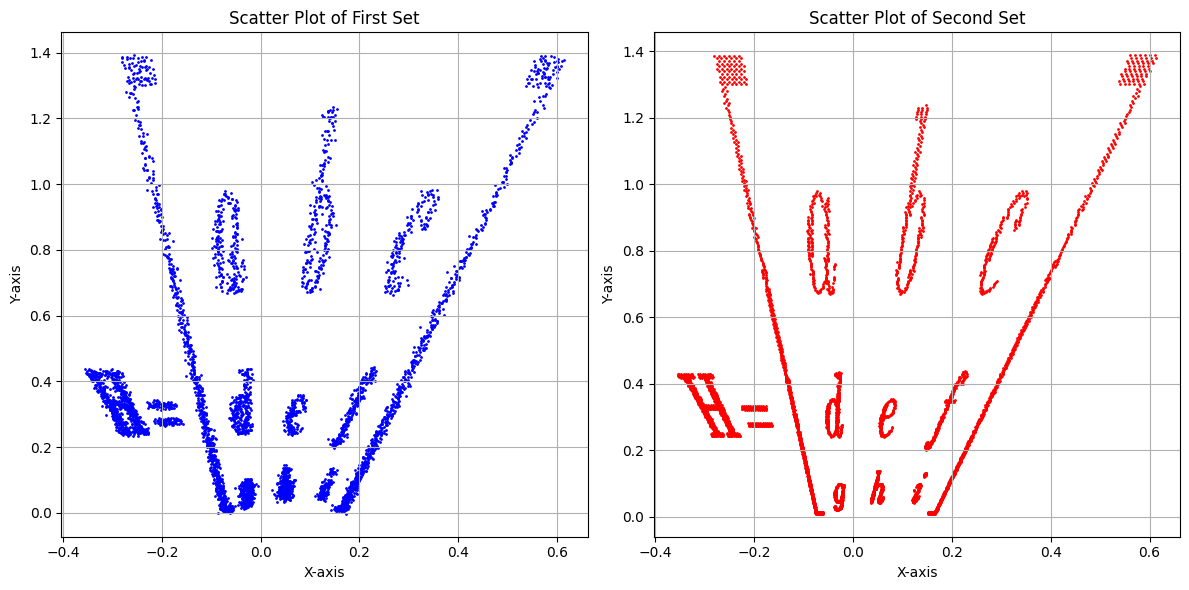

In [ ]:
# Convert the 2D point to homogeneous coordinates by
# adding a third coordinate with a value of 1
x_homo = np.hstack((x, ov))

# Apply the homography by matrix multiplication
xh_homo = H @ x_homo.T

# Convert the transformed homogeneous coordinates back to 2D by
# dividing the first two components by the third (the scaling factor)
xh = xh_homo[:2, :] / xh_homo[2, :].reshape(1, -1)

plot_points(xp, xh.T)

## 6.2 Effects of Outliers

We introduce noise into the dataset by adding Guassian noise with variance of $\sigma$ and a bias $b$ to the last 1,000 points.

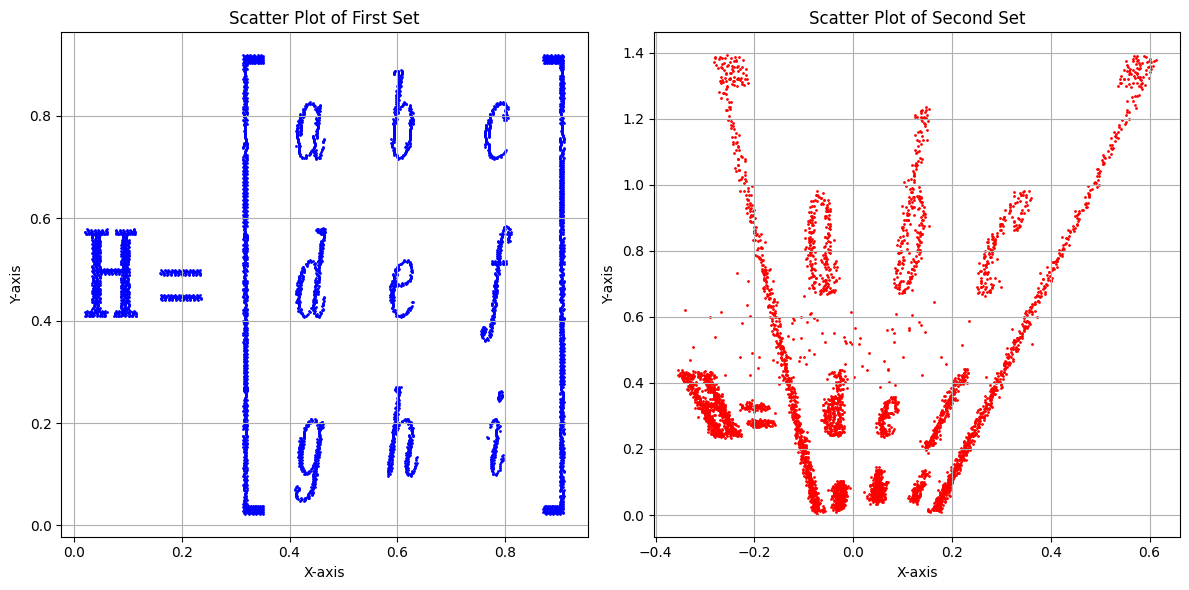

In [ ]:
bias_x = -0.1
bias_y = 0.5
var_x = 0.01
var_y = 0.01

# Genearte noise
gaus_noise_x = np.random.normal(bias_x, np.sqrt(var_x), size=(100, 1))
gaus_noise_y = np.random.normal(bias_y, np.sqrt(var_y), size=(100, 1))
gaus_noise = np.hstack((gaus_noise_x, gaus_noise_y))

# Add the noise to the last 1000 points in the dataset
datan = np.load("points_case_2.npy")
datan[-100:, -2:] += gaus_noise
xn = datan[:, :2]
xpn = datan[:, -2:]
plot_points(xn, xpn)

Define the function `fit_homography()` to fit a Homography transformation from a set of correspondences.

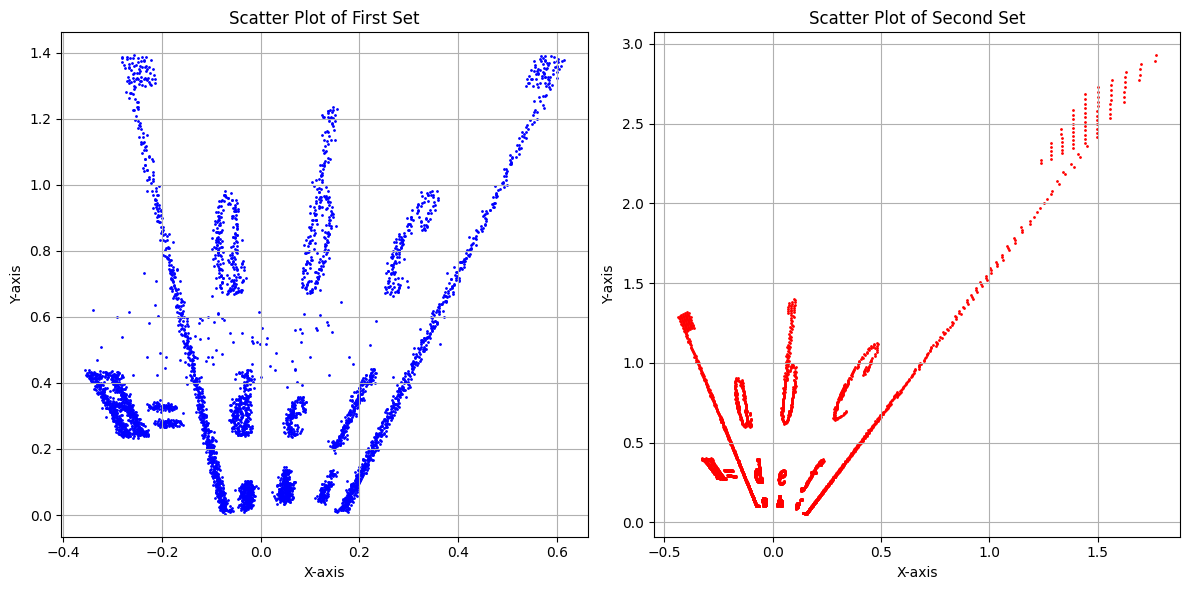

In [ ]:
def fit_homography(x, xp):
    zm = np.zeros((x.shape[0], 3)) # Nx3 zero matrix
    ov = np.ones((x.shape[0], 1)) # vector of ones

    xpx = xp[:,0].reshape(-1, 1) # x'
    xpy = xp[:,1].reshape(-1, 1) # y'

    # Construct A matrix
    A_even = np.hstack((zm, -x, -ov, xpy*x, xpy))
    A_odd = np.hstack((x, ov, zm, -xpx*x, -xpx))

    A = np.empty((2*x.shape[0], 9))
    A[0::2] = A_even
    A[1::2] = A_odd

    # Perform SVD on matrix A
    U, D, Vt = np.linalg.svd(A)
    V = Vt.T
    homogeneous_solution = V[:, -1]
    H = homogeneous_solution.reshape(3, 3)

    return H

# Apply fit_homography() with noisy dataset
Hn = fit_homography(xn, xpn)

# Apply the homography by matrix multiplication
ov = np.ones((xn.shape[0], 1))
xn_homo = np.hstack((xn, ov))
xhn_homo = Hn @ xn_homo.T

# Convert the transformed homogeneous coordinates back to 2D
xhn = xhn_homo[:2, :] / xhn_homo[2, :].reshape(1, -1)

plot_points(xpn, xhn.T)

## 6.3 RANSAC

Employ RANSAC (Random Sample Consensus) which is a robust regression technique to handle the outliers.

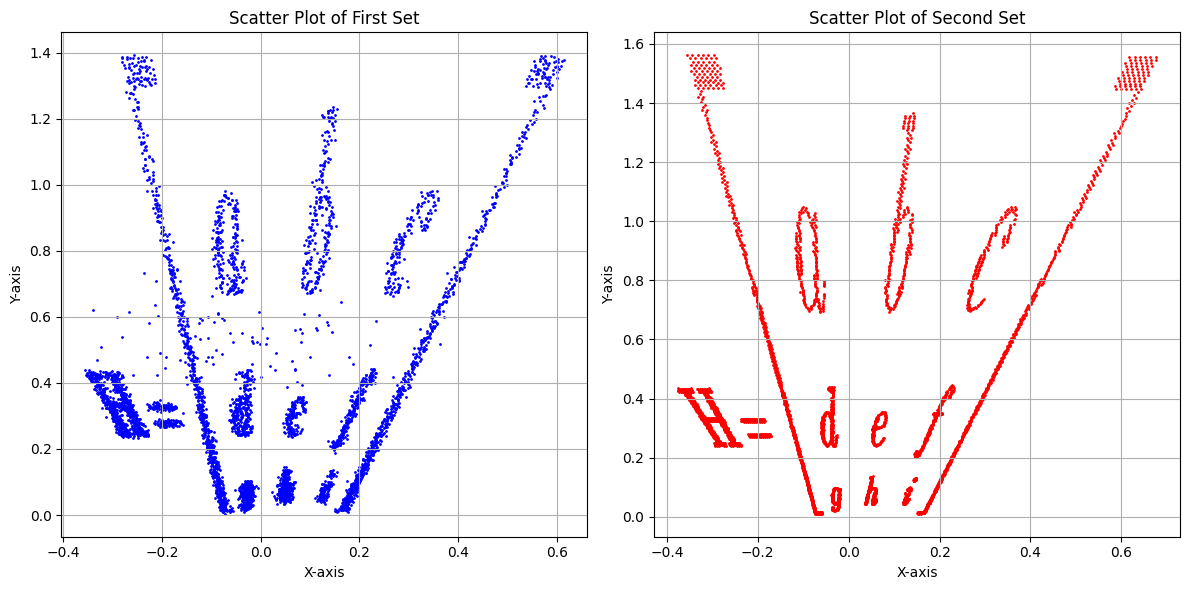

In [ ]:
import random

def RANSAC_fit_homography(x, xp, nIters=1000, threshold=1 ):
    bestNumInliers = 0
    bestInliers = None

    for _ in range(nIters):
      # 1. Randomly sample 3 correspondances
      sample_indices = random.sample(range(x.shape[0]), 3)
      sample_x = x[sample_indices]
      sample_xp = xp[sample_indices]

      # 2. Fit affine transformation
      H = fit_homography(sample_x, sample_xp)

      # 3. Find best fit model
      num_inliers = 0
      inliers = []
      for i in range(x.shape[0]):
        x_homo = np.array( [[x[i,0]],[x[i,1]],[1]] )
        xh_homo = H @ x_homo
        xh = xh_homo[:2, :] / xh_homo[2, :].reshape(1, -1)

        # Compute the distance to the actual points
        err = np.linalg.norm(xp[i].T - xh)

        if err < threshold:
          num_inliers += 1
          inliers.append(i)

      # Update the best model if the current one has more inliers
      if num_inliers > bestNumInliers:
        bestNumInliers = num_inliers
        bestInliers = inliers

    bestH = fit_homography(x[bestInliers], xp[bestInliers])

    return bestH

# Apply RANSAC with noise dataset
H_ransac = RANSAC_fit_homography(xn, xpn, nIters=100, threshold=0.2)

xn_homo = np.hstack((xn, ov))
xh_ransac_homo = H_ransac @ xn_homo.T

# Convert the transformed homogeneous coordinates back to 2D
xh_ransac = xh_ransac_homo[:2, :] / xh_ransac_homo[2, :].reshape(1, -1)

plot_points(xpn, xh_ransac.T)